## 1. Catboost, optuna 설치

In [ ]:
!pip install catboost -q
!pip install optuna -q

## 2. 라이브러리 불러오기

In [ ]:
import os
import sys
import platform, psutil
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# 모델
import sklearn 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score
import catboost
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler

np.random.seed(777)

In [ ]:
# 개발환경(OS) 및 라이브러리 버전
print(f"- os: {platform.platform()}")
print(f"- Process information: {platform.processor()}")
print(f"- Process Architecture: {platform.machine()}")
print(f"- RAM Size: {str(round(psutil.virtual_memory().total / (1024.0 **3)))} GB")
print()
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- catboost: {catboost.__version__}")
print(f"- optuna: {optuna.__version__}")

- os: Linux-5.4.0-91-generic-x86_64-with-debian-buster-sid
- Process information: x86_64
- Process Architecture: x86_64
- RAM Size: 252 GB

- python: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
- pandas: 1.0.1
- numpy: 1.18.1
- sklearn: 0.22.1
- catboost: 1.0.4
- optuna: 2.10.0


## 3. 데이터 불러오기

In [ ]:
train = pd.read_csv('./data/train.csv')
D_code = pd.read_csv('./data/속성_D_코드.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv("./data/sample_submission.csv")

## 4. 탐색적 자료 분석 (EDA)

#### 4-1. 데이터 기초 통계

In [ ]:
# train 데이터와 test 데이터의 전반적인 정보 확인
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501951 entries, 0 to 501950
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      501951 non-null  int64 
 1   d_l_match_yn            501951 non-null  bool  
 2   d_m_match_yn            501951 non-null  bool  
 3   d_s_match_yn            501951 non-null  bool  
 4   h_l_match_yn            501951 non-null  bool  
 5   h_m_match_yn            501951 non-null  bool  
 6   h_s_match_yn            501951 non-null  bool  
 7   person_attribute_a      501951 non-null  int64 
 8   person_attribute_a_1    501951 non-null  int64 
 9   person_attribute_b      501951 non-null  int64 
 10  person_prefer_c         501951 non-null  int64 
 11  person_prefer_d_1       501951 non-null  int64 
 12  person_prefer_d_2       501951 non-null  int64 
 13  person_prefer_d_3       501951 non-null  int64 
 14  person_prefer_e         501951 non-n

- d_l_match_yn ~ h_s_match_yn 변수 타입이 bool로 되어 있는 걸 확인할 수 있음
- 시계열 변수를 제외한 변수들은 모두 범주형 변수
- NaN이 존재 하지 않음

In [ ]:
# train 데이터와 test 데이터의 기초 통계량 확인
pd.options.display.max_columns = None
display(train.describe(), test.describe())

,id,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target
count,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.0,501951.0,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,501951.000000,5.019510e+05,501951.000000,501951.00000
mean,250975.000000,1.340055,2.575767,2.782742,2.380049,537.296399,545.833926,534.994095,3.626302,1.0,1.0,116.394919,136.011991,122.784720,2.447811,2.332622,5.893970,1.237806,1.386052,1.963307,1030.863194,581.505215,2.240486,3.922988,132.530916,5.141115e+05,337674.345074,0.49974
std,144900.916822,0.473728,2.390872,0.883072,1.827910,411.441926,403.328742,415.752072,1.846717,0.0,0.0,91.032989,93.756209,90.947916,0.842948,0.887333,2.143146,0.425740,0.793128,0.188007,527.235733,413.915756,1.556468,1.159992,87.142309,2.943547e+05,219518.485557,0.50000
min,0.000000,1.000000,0.000000,0.000000,1.000000,4.000000,4.000000,4.000000,0.000000,1.0,1.0,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.000000,5.000000,7.000000e+00,20.000000,0.00000
25%,125487.500000,1.000000,0.000000,2.000000,1.000000,117.000000,148.000000,136.000000,3.000000,1.0,1.0,44.000000,59.000000,59.000000,2.000000,1.000000,5.000000,1.000000,1.000000,2.000000,597.000000,138.000000,1.000000,3.000000,57.000000,2.599785e+05,140899.000000,0.00000
50%,250975.000000,1.000000,2.000000,3.000000,1.000000,453.000000,464.000000,452.000000,4.000000,1.0,1.0,95.000000,116.000000,95.000000,3.000000,3.000000,5.000000,1.000000,1.000000,2.000000,953.000000,581.000000,1.000000,4.000000,118.000000,4.981190e+05,304996.000000,0.00000
75%,376462.500000,2.000000,5.000000,4.000000,5.000000,935.000000,963.000000,929.000000,5.000000,1.0,1.0,189.000000,227.000000,200.000000,3.000000,3.000000,5.000000,1.000000,1.000000,2.000000,1582.000000,974.000000,4.000000,4.000000,199.000000,7.656345e+05,535184.000000,1.00000
max,501950.000000,2.000000,7.000000,5.000000,5.000000,1258.000000,1258.000000,1258.000000,11.000000,1.0,1.0,313.000000,313.000000,313.000000,3.000000,3.000000,10.000000,2.000000,4.000000,2.000000,2013.000000,1258.000000,5.000000,11.000000,311.000000,1.049005e+06,753628.000000,1.00000


,id,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn
count,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.0,46404.0,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,46404.000000,4.640400e+04,46404.000000
mean,23201.500000,1.355228,2.521097,2.777282,2.440156,550.401452,558.499914,542.512779,3.627726,1.0,1.0,117.651431,136.335639,121.951556,2.436449,2.364408,5.873567,1.239936,1.482609,1.965800,1073.661775,591.182958,2.298164,3.929467,132.014675,5.180232e+05,338310.929791
std,13395.825283,0.478588,2.402751,0.892773,1.843153,405.639803,397.592315,409.745525,1.840738,0.0,0.0,92.171941,93.970565,91.587486,0.845824,0.878988,2.147279,0.427049,0.864565,0.181744,539.545363,404.253447,1.562128,1.179987,87.976082,2.938689e+05,220499.106553
min,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,0.000000,1.0,1.0,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,0.000000,5.000000,5.980000e+02,4777.000000
25%,11600.750000,1.000000,0.000000,2.000000,1.000000,122.000000,175.000000,143.000000,3.000000,1.0,1.0,43.000000,59.000000,56.000000,2.000000,1.000000,5.000000,1.000000,1.000000,2.000000,631.000000,144.000000,1.000000,3.000000,57.000000,2.547488e+05,143397.000000
50%,23201.500000,1.000000,2.000000,3.000000,1.000000,499.000000,514.000000,499.000000,4.000000,1.0,1.0,95.000000,116.000000,95.000000,3.000000,3.000000,5.000000,1.000000,1.000000,2.000000,987.000000,665.000000,1.000000,4.000000,117.000000,4.966195e+05,303475.500000
75%,34802.250000,2.000000,5.000000,4.000000,5.000000,929.000000,935.000000,910.000000,5.000000,1.0,1.0,190.000000,227.000000,195.000000,3.000000,3.000000,5.000000,1.000000,1.000000,2.000000,1645.000000,969.000000,4.000000,4.000000,199.000000,7.643680e+05,530566.000000
max,46403.000000,2.000000,7.000000,5.000000,5.000000,1257.000000,1256.000000,1258.000000,11.000000,1.0,1.0,313.000000,313.000000,313.000000,3.000000,3.000000,10.000000,2.000000,4.000000,2.000000,1998.000000,1256.000000,5.000000,11.000000,311.000000,1.048983e+06,753648.000000


- -9999, 9999 등의 숫자가 보이지 않는 것으로 보아 결측치 및 이상치가 존재하지 않음
- person_prefer_f와 person_prefer_g는 label이 1만 존재함

In [ ]:
# 중복 사용자 번호 확인
display(train.duplicated(['person_rn']).tail(), train['person_rn'].tail(), train['contents_rn'][train["person_rn"]==235596].head())

501946     True
501947     True
501948    False
501949     True
501950     True
dtype: bool

501946    503156
501947    676255
501948    484528
501949    456330
501950    235596
Name: person_rn, dtype: int64

170980    134547
310584    136006
317149    125516
338374    124695
355164    164677
Name: contents_rn, dtype: int64

- 한 사용자가 여러개의 컨텐츠를 확인하는 경우가 존재

In [ ]:
# 데이터 불균형 확인
train['target'].value_counts()

0    251106
1    250845
Name: target, dtype: int64

- 데이터가 불균형하지 않음

#### 4-2. 데이터 시각화

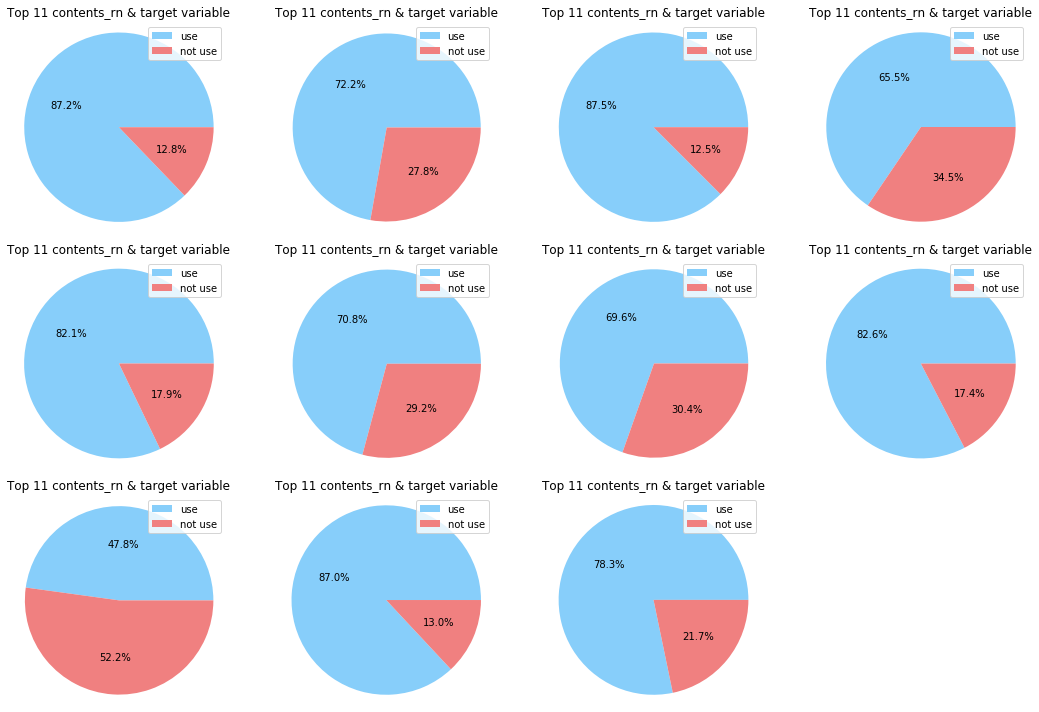

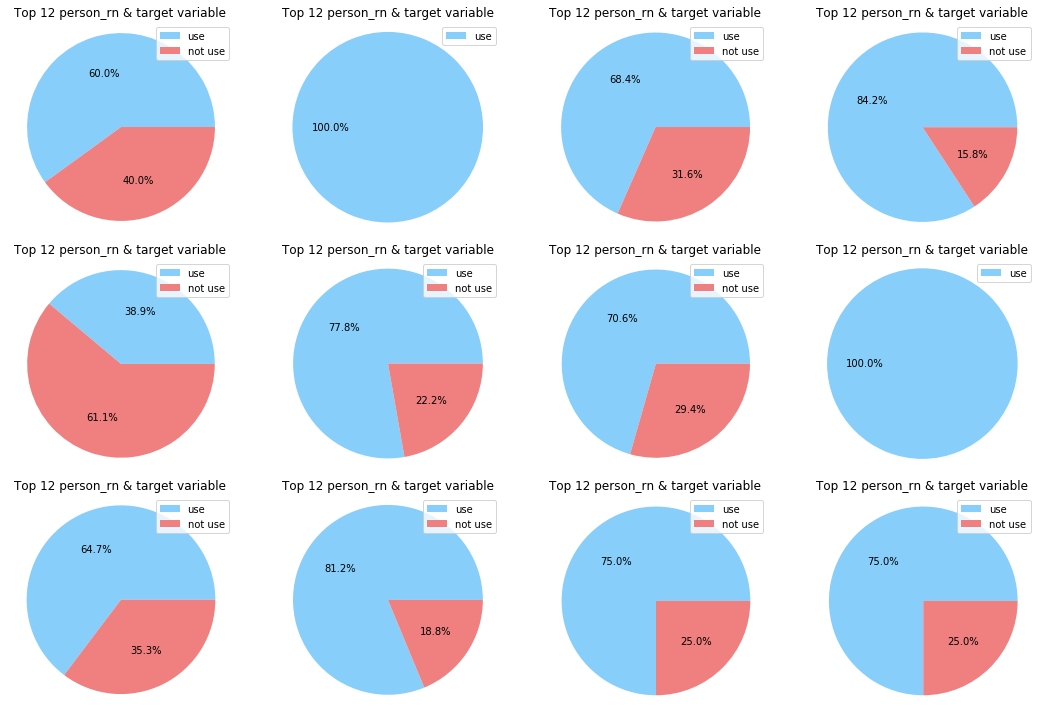

In [ ]:
# 높은 빈도수를 보이는 상위 11개의 컨텐츠번호와 컨텐츠 사용 여부 시각화
colors = ['lightskyblue', 'lightcoral']
plt.figure(figsize=(15,10))
for i in range(0,11):
    ax = plt.subplot(3,4,i+1)
    plt.pie(train[train["contents_rn"]==train.contents_rn.value_counts().nlargest(11).index[i]].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.title("Top 11 contents_rn & target variable")
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

# 높은 빈도수를 보이는 상위 12개의 컨텐츠번호와 컨텐츠 사용 여부 시각화
plt.figure(figsize=(15,10))
for i in range(0,12):
    ax = plt.subplot(3,4,i+1)
    plt.pie(train[train["person_rn"]==train.person_rn.value_counts().nlargest(12).index[i]].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.title("Top 12 person_rn & target variable")
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

- 많은 빈도수를 보이는 **컨텐츠**일수록, 대부분 컨텐츠를 많이 사용하는 경향을 보임
- 많은 빈도수를 보이는 **사용자**일수록, 대부분 컨텐츠를 많이 사용하는 경향을 보임
- 따라서 컨텐츠 빈도수와 사용자 빈도수 변수를 생성할 것임

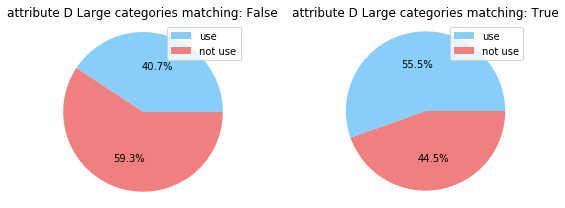

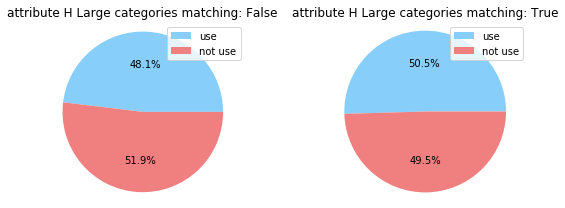

In [ ]:
# bool type 변수를 0, 1의 int64 type으로 변경해줌
for i in range(len(train.columns)):
    if train.dtypes[i] == 'bool':
        train.iloc[:,i] = train.iloc[:,i].apply(lambda x: 1 if x==True else 0)

# 속성 D와 속성 H의 대분류 매칭 여부 변수 시각화
plt.figure(figsize=(8, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("attribute D Large categories matching: %s"%bool(i))
    plt.pie(train[train["d_l_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.pie(train[train["h_l_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.title("attribute H Large categories matching: %s"%bool(i))
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

- 회원 선호 속성 D 1번 대분류코드와 컨텐츠 속성 D 대분류코드가 동일하지 않은 경우, 컨텐츠 사용을 하지 않는 경향을 보임
- 회원 선호 속성 D 1번 대분류코드와 컨텐츠 속성 D 대분류코드가 동일한 경우, 컨텐츠 사용을 하는 경향을 보임
- 회원 선호 속성 H 1번 대분류코드와 컨텐츠 속성 H 대분류코드가 동일하지 않은 경우와 동일한 경우 모두 컨텐츠 사용과 큰 관련성이 없어보임

In [ ]:
# train 변수를 다른 곳에 저장
train_origin = train.copy()

# 속성 D 1번, 2번, 3번의 대분류, 중분류, 소분류, 세분류, 코드 매칭 여부 변수 생성을 위한 데이터 처리
d1 = D_code.copy()
d1.columns = ['person_prefer_d_1', 'person_prefer_d_1_m', 'person_prefer_d_1_sm', 'person_prefer_d_1_me', 'person_prefer_d_1_l']
d2 = D_code.copy()
d2.columns = ['person_prefer_d_2', 'person_prefer_d_2_m', 'person_prefer_d_2_sm', 'person_prefer_d_2_me', 'person_prefer_d_2_l']
d3 = D_code.copy()
d3.columns = ['person_prefer_d_3', 'person_prefer_d_3_m', 'person_prefer_d_3_sm', 'person_prefer_d_3_me', 'person_prefer_d_3_l']
con_d = D_code.copy()
con_d.columns = ['contents_attribute_d', 'contents_attribute_d_m', 'contents_attribute_d_sm', 'contents_attribute_d_me', 'contents_attribute_d_l']

# 속성 D merge
train = pd.merge(train, d1, on="person_prefer_d_1")
train = pd.merge(train, d2, on="person_prefer_d_2")
train = pd.merge(train, d3, on="person_prefer_d_3")
train = pd.merge(train, con_d, on="contents_attribute_d")

# 속성 D의 매칭 여부 변수를 만드는 함수
def match(col1, col2, col3):
    train[col1] = train.apply(lambda x: 1 if x[col2]==x[col3] else 0, axis=1)

# 속성 D의 대분류 매칭 여부 변수 생성
match("d_1_l_match_yn","person_prefer_d_1_l","contents_attribute_d_l")
match("d_2_l_match_yn","person_prefer_d_2_l","contents_attribute_d_l")
match("d_3_l_match_yn","person_prefer_d_3_l","contents_attribute_d_l")
# 속성 D의 중분류 매칭 여부 변수 생성
match("d_1_me_match_yn","person_prefer_d_1_me","contents_attribute_d_me")
match("d_2_me_match_yn","person_prefer_d_2_me","contents_attribute_d_me")
match("d_3_me_match_yn","person_prefer_d_3_me","contents_attribute_d_me")
# 속성 D의 소분류 매칭 여부 변수 생성
match("d_1_sm_match_yn","person_prefer_d_1_sm","contents_attribute_d_sm")
match("d_2_sm_match_yn","person_prefer_d_2_sm","contents_attribute_d_sm")
match("d_3_sm_match_yn","person_prefer_d_3_sm","contents_attribute_d_sm")
# 속성 D의 세분류 매칭 여부 변수 생성
match("d_1_m_match_yn","person_prefer_d_1_m","contents_attribute_d_m")
match("d_2_m_match_yn","person_prefer_d_2_m","contents_attribute_d_m")
match("d_3_m_match_yn","person_prefer_d_3_m","contents_attribute_d_m")
# 속성 D의 코드 매칭 여부 변수 생성
match("d_1_s_match_yn","person_prefer_d_1","contents_attribute_d")
match("d_2_s_match_yn","person_prefer_d_2","contents_attribute_d")
match("d_3_s_match_yn","person_prefer_d_3","contents_attribute_d")

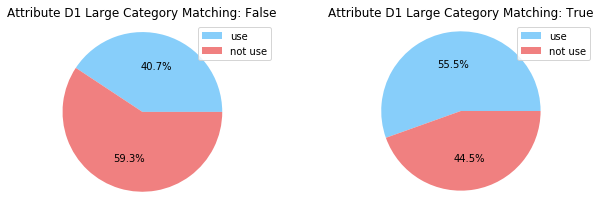

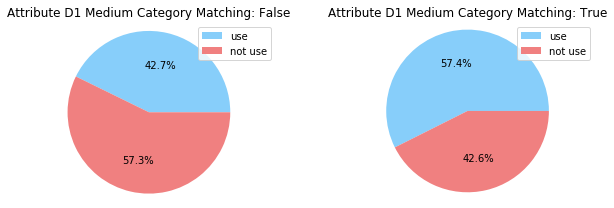

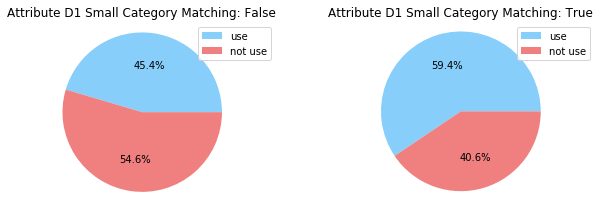

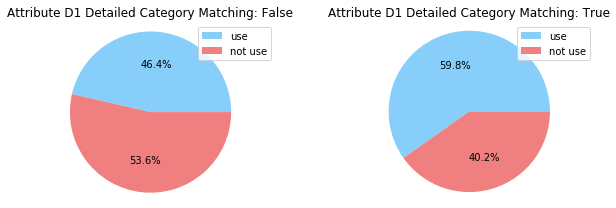

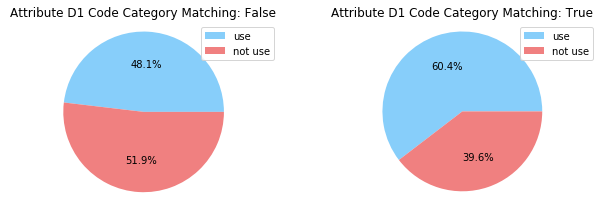

In [ ]:
# 속성 D 1번의 매칭 여부 변수 시각화
plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D1 Large Category Matching: %s"%bool(i))
    plt.pie(train[train["d_1_l_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D1 Medium Category Matching: %s"%bool(i))
    plt.pie(train[train["d_1_me_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D1 Small Category Matching: %s"%bool(i))
    plt.pie(train[train["d_1_sm_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D1 Detailed Category Matching: %s"%bool(i))
    plt.pie(train[train["d_1_m_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D1 Code Category Matching: %s"%bool(i))
    plt.pie(train[train["d_1_s_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

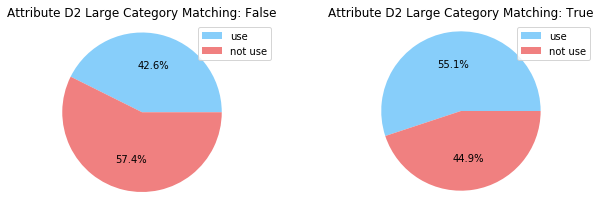

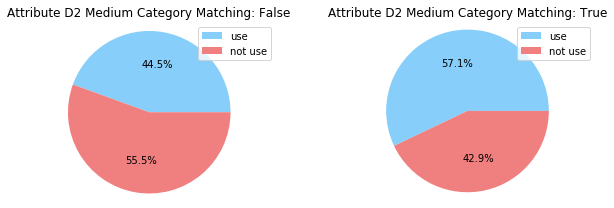

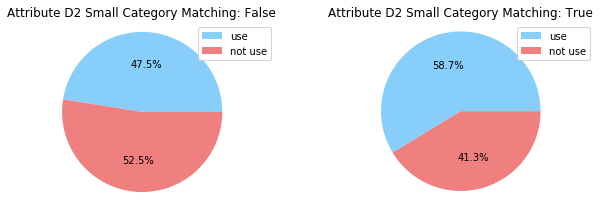

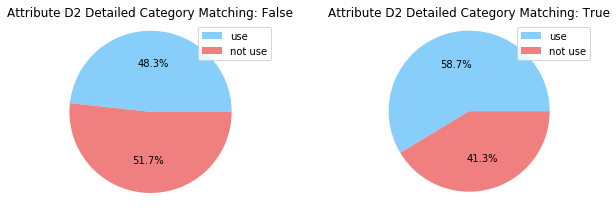

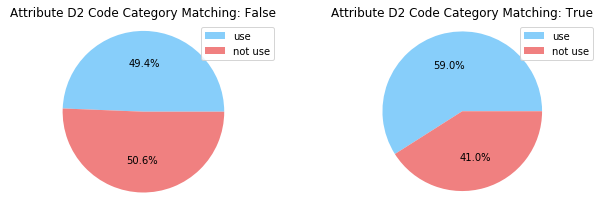

In [ ]:
# 속성 D 2번의 매칭 여부 변수 시각화
plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D2 Large Category Matching: %s"%bool(i))
    plt.pie(train[train["d_2_l_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D2 Medium Category Matching: %s"%bool(i))
    plt.pie(train[train["d_2_me_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D2 Small Category Matching: %s"%bool(i))
    plt.pie(train[train["d_2_sm_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D2 Detailed Category Matching: %s"%bool(i))
    plt.pie(train[train["d_2_m_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D2 Code Category Matching: %s"%bool(i))
    plt.pie(train[train["d_2_s_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

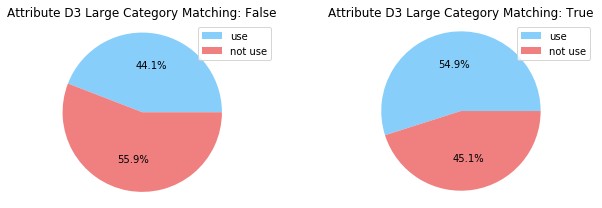

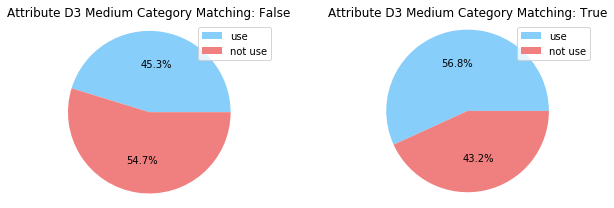

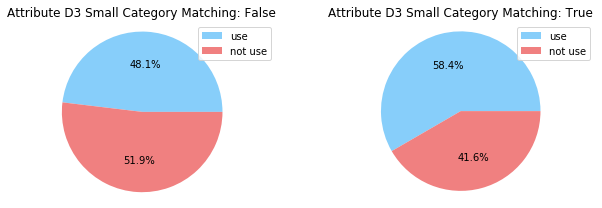

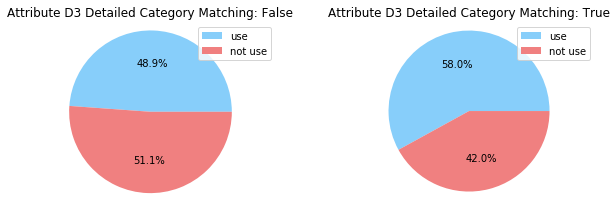

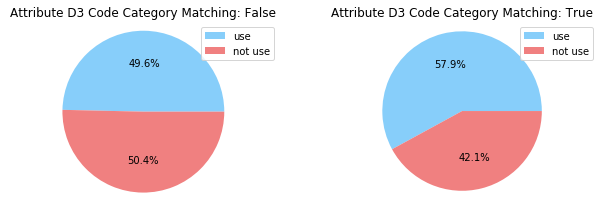

In [ ]:
# 속성 D 3번의 매칭 여부 변수 시각화
plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D3 Large Category Matching: %s"%bool(i))
    plt.pie(train[train["d_3_l_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D3 Medium Category Matching: %s"%bool(i))
    plt.pie(train[train["d_3_me_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D3 Small Category Matching: %s"%bool(i))
    plt.pie(train[train["d_3_sm_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D3 Detailed Category Matching: %s"%bool(i))
    plt.pie(train[train["d_3_m_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
for i in range(0,2):
    ax = plt.subplot(1,2,i+1)
    plt.title("Attribute D3 Code Category Matching: %s"%bool(i))
    plt.pie(train[train["d_3_s_match_yn"]==i].target.value_counts().sort_index(ascending = False), colors=colors, autopct='%.1f%%')
    plt.legend(['use','not use'])
    plt.axis('equal')
plt.tight_layout()
plt.show()

- 컨텐츠속성 D의 코드 매칭이 이루어지지 않은 경우, 대분류로 갈 수록 target 변수의 차이가 두드러짐
- 컨텐츠속성 D의 코드 매칭이 이루어진 경우: 대분류로 갈 수록 target 변수의 차이가 두드러지지 않음
- 따라서 컨텐츠 속성 D의 매칭 여부 변수는 대분류와 코드 매칭 여부만 생성할 것임

In [ ]:
# 시계열 변수를 그대로 사용할 수 없으므로 요일, 시간으로 날짜 변수를 만들어줌
# 월 변수는 train data에서 1~11월, test data에서 12월로 구성되어 있기 때문에 적합하지 않다고 판단해 생성하지 않음
train["contents_open_dt"] = pd.to_datetime(train["contents_open_dt"])
train["contents_open_wd"] = train.contents_open_dt.dt.weekday
train["contents_open_hour"] = train.contents_open_dt.dt.hour

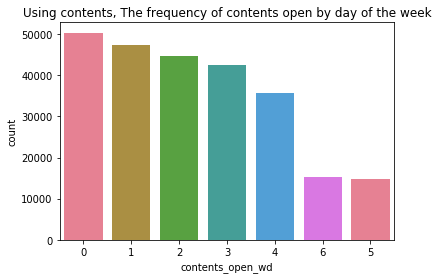

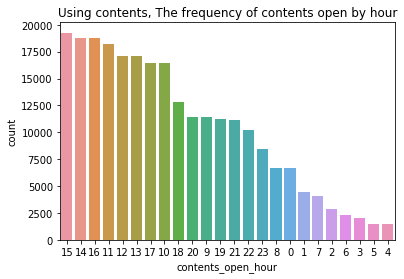

target,0,1
contents_open_wd,,
0,49979,50291
1,47657,47405
2,44171,44744
3,42724,42574
4,35509,35646
5,15170,14876
6,15896,15309


target,0,1
contents_open_hour,,
0,7504,6643
1,5520,4411
2,3592,2834
3,2417,2029
4,1874,1473
5,1837,1519
6,2559,2300
7,4194,4118
8,6075,6676


In [ ]:
sns.countplot(x="contents_open_wd", data=train[train["target"]==1], order=train.contents_open_wd[train["target"]==1].value_counts().index, palette=sns.color_palette("husl"))
plt.title("Using contents, The frequency of contents open by day of the week")
plt.show()

sns.countplot(x="contents_open_hour", data=train[train["target"]==1], order=train.contents_open_hour[train["target"]==1].value_counts().index)
plt.title("Using contents, The frequency of contents open by hour")
plt.show()

display(pd.crosstab(train.contents_open_wd, train.target), pd.crosstab(train.contents_open_hour, train.target))

- 컨텐츠를 사용하는 경우, 평일 및 10시부터 17시까지 활발함
- 주말(contents_open_wd=5, 6)의 경우 컨텐츠 사용을 안하는 경우가 많음
- 10시부터 17시 정도에 컨텐츠를 사용하는 경우가 많음

## 5. 데이터 전처리

In [ ]:
# 원래 데이터 불러오기
train = train_origin.copy()
del train_origin

# 속성 D 1번, 2번, 3번의 대분류, 코드 매칭 여부 변수 생성을 위한 데이터 처리
d1 = D_code.copy()
d1 = d1.iloc[:,[0,4]]
d1.columns = ['person_prefer_d_1', 'person_prefer_d_1_l']
d2 = D_code.copy()
d2 = d2.iloc[:,[0,4]]
d2.columns = ['person_prefer_d_2', 'person_prefer_d_2_l']
d3 = D_code.copy()
d3 = d3.iloc[:,[0,4]]
d3.columns = ['person_prefer_d_3', 'person_prefer_d_3_l']
con_d = D_code.copy()
con_d = con_d.iloc[:,[0,4]]
con_d.columns = ['contents_attribute_d', 'contents_attribute_d_l']

# 전처리를 위한 함수 생성
def preprocessing_1(data):
    # Bool to category
    for i in range(len(data.columns)):
        if data.dtypes[i] == 'bool':
            data.iloc[:,i] = data.iloc[:,i].apply(lambda x: 1 if x==True else 0)

    # 날짜 변수 생성
    data["contents_open_dt"] = pd.to_datetime(data["contents_open_dt"])
    data["contents_open_wd"] = data.contents_open_dt.dt.weekday
    data["contents_open_hour"] = data.contents_open_dt.dt.hour
    data['contents_weekday'] = data.apply(lambda x: 1 if x['contents_open_wd'] not in [5, 6] else 0, axis=1) # 평일 및 주말
    data['contents_work_time'] = data.apply(lambda x: 1 if x['contents_open_hour'] in [10,11,12,13,14,15,16,17] else 0, axis=1) # 시간대

    # 컨텐츠 번호 빈도수 변수 생성
    contents_rn_cnt=data.groupby(data["contents_rn"]).size()
    contents_rn_cnt.name="contents_rn_cnt"
    data = pd.merge(data, contents_rn_cnt, on="contents_rn")

    # 사용자 번호 빈도수 변수 생성
    person_rn_cnt=data.groupby(data["person_rn"]).size()
    person_rn_cnt.name="person_rn_cnt"
    data = pd.merge(data, person_rn_cnt, on="person_rn")

    # 속성 D merge
    data = pd.merge(data, d1, on="person_prefer_d_1")
    data = pd.merge(data, d2, on="person_prefer_d_2")
    data = pd.merge(data, d3, on="person_prefer_d_3")
    data = pd.merge(data, con_d, on="contents_attribute_d")
    
    return data

# 전처리
train = preprocessing_1(train)
test = preprocessing_1(test)

# 속성 D의 1번, 2번, 3번의 대분류 및 코드 매칭 여부 변수를 만드는 함수
def match(data, col1, col2, col3):
    data[col1] = data.apply(lambda x: 1 if x[col2]==x[col3] else 0, axis=1)
    
# 속성 D의 대분류 매칭 여부 변수 생성
match(train, "d_1_l_match_yn", "person_prefer_d_1_l", "contents_attribute_d_l")
match(train, "d_2_l_match_yn", "person_prefer_d_2_l", "contents_attribute_d_l")
match(train, "d_3_l_match_yn", "person_prefer_d_3_l", "contents_attribute_d_l")
match(test, "d_1_l_match_yn", "person_prefer_d_1_l", "contents_attribute_d_l")
match(test, "d_2_l_match_yn", "person_prefer_d_2_l", "contents_attribute_d_l")
match(test, "d_3_l_match_yn", "person_prefer_d_3_l", "contents_attribute_d_l")

# 속성 D의 코드 매칭 여부 변수 생성
match(train, "d_1_s_match_yn", "person_prefer_d_1", "contents_attribute_d")
match(train, "d_2_s_match_yn", "person_prefer_d_2", "contents_attribute_d")
match(train, "d_3_s_match_yn", "person_prefer_d_3", "contents_attribute_d")
match(test, "d_1_s_match_yn", "person_prefer_d_1", "contents_attribute_d")
match(test, "d_2_s_match_yn", "person_prefer_d_2", "contents_attribute_d")
match(test, "d_3_s_match_yn", "person_prefer_d_3", "contents_attribute_d")

# id에 대하여 데이터 정렬
train = train.sort_values(by='id')
test = test.sort_values(by='id')

# 필요 없는 열 제거
''' 아이디(id), label이 하나인 경우('person_prefer_f', 'person_prefer_g'),
    사용자 번호(person_rn), 컨텐츠 번호(contents_rn), 컨텐츠 열람 일시(contents_open_dt),
    기존에 있었던 속성 D 매칭 여부 변수(d_l_match_yn, d_m_match_yn, d_s_match_yn), 속성 H 중분류 및 코드 매칭 여부(h_m_match_yn, h_s_match_yn),
    merge 하면서 생긴 속성 D 대분류 코드(person_prefer_d_1_l, person_prefer_d_2_l, person_prefer_d_3_l, contents_attribute_d_l)'''

train.drop(['id','person_prefer_f','person_prefer_g','person_rn','contents_rn','contents_open_dt',
            'd_l_match_yn','d_m_match_yn','d_s_match_yn', "h_m_match_yn", "h_s_match_yn",
            'person_prefer_d_1_l', 'person_prefer_d_2_l', 'person_prefer_d_3_l', 'contents_attribute_d_l'], axis=1, inplace=True)

test.drop(['id','person_prefer_f','person_prefer_g','person_rn','contents_rn','contents_open_dt',
            'd_l_match_yn','d_m_match_yn','d_s_match_yn', "h_m_match_yn", "h_s_match_yn",
            'person_prefer_d_1_l', 'person_prefer_d_2_l', 'person_prefer_d_3_l', 'contents_attribute_d_l'], axis=1, inplace=True)

# 인덱스 재정렬
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

- 아이디, label이 하나인 경우, 사용자 번호, 컨텐츠 번호, 컨텐츠 열람 일시 변수의 경우 모델 생성에 필요하지 않은 변수
- 기존에 있었던 속성 D 매칭 여부 변수는 속성 D의 1번, 2번, 3번의 대분류 및 코드 매칭 여부 변수를 따로 만들어주었으므로 제거해줌
- 속성 H 중분류 및 코드 매칭 여부 변수는 속성 H 대분류 매칭 여부 변수와 관련성이 높으며, 앞서 시각화에서 봤듯이 속성 H 코드 매칭 여부 변수가 target 변수 분류에 큰 영향을 주지 않을 것이라고 판단해 속성 H 대분류 매칭 여부 변수만 남겨줌

## 6. 모델 생성

In [ ]:
# 데이터 셋 나누기
X = train.drop('target', axis=1)
y = train['target']
X_test = test.copy()

In [ ]:
# Optuna를 통한 하이퍼 파라미터 설정
def objective(trial):
    param = {"random_state": 777,
             "learning_rate": trial.suggest_loguniform('learning_rate', 0.01, 0.2),
             "bagging_temperature": trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
             "n_estimators": trial.suggest_int("n_estimators", 1000, 10000),
             "max_depth": trial.suggest_int("max_depth", 4, 16),
             "random_strength": trial.suggest_int('random_strength', 0, 100),
             "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 1.0),
             "l2_leaf_reg": trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
             "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
             "max_bin": trial.suggest_int("max_bin", 200, 500),
             "od_type": trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])}

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=777)
    cat = CatBoostClassifier(**param)
    cat.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid,y_valid)],
            early_stopping_rounds=35, verbose=False,
            cat_features=X_train.drop(['contents_rn_cnt', 'person_rn_cnt'], axis=1).columns.tolist())
    cat_pred = cat.predict(X_valid)
    f1 = f1_score(y_valid, cat_pred)

    return f1

study = optuna.create_study(study_name = 'cat_parameter_opt', direction = 'maximize', sampler = TPESampler(seed=777))
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial", study.best_trial.params)

[I 2022-01-30 07:26:17,477] A new study created in memory with name: cat_parameter_opt
[I 2022-01-30 07:42:20,317] Trial 0 finished with value: 0.6856973452681508 and parameters: {'learning_rate': 0.01579865438088323, 'bagging_temperature': 0.16196696296443755, 'n_estimators': 1558, 'max_depth': 9, 'random_strength': 84, 'colsample_bylevel': 0.9561982286499368, 'l2_leaf_reg': 2.1812399639728913e-05, 'min_child_samples': 78, 'max_bin': 281, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.6856973452681508.
[I 2022-01-30 08:20:08,661] Trial 1 finished with value: 0.6666345105681019 and parameters: {'learning_rate': 0.012696199189652336, 'bagging_temperature': 2.2827324567331666, 'n_estimators': 4090, 'max_depth': 16, 'random_strength': 63, 'colsample_bylevel': 0.8090675678685719, 'l2_leaf_reg': 1.6572181843977423e-05, 'min_child_samples': 30, 'max_bin': 312, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.6856973452681508.
[I 2022-01-30 08:30:15,030] Trial 2 finished with valu

Best Score: 0.6938205204275966
Best trial {'learning_rate': 0.04031140044870307, 'bagging_temperature': 47.87071560332222, 'n_estimators': 7554, 'max_depth': 7, 'random_strength': 1, 'colsample_bylevel': 0.8235932881616793, 'l2_leaf_reg': 2.323674135181441e-05, 'min_child_samples': 50, 'max_bin': 441, 'od_type': 'Iter'}


In [ ]:
# K-fold 교차 검증을 통한 과적합 방지
is_holdout = False
cv = KFold(n_splits=5, shuffle=True, random_state=777)
scores = []
models = []
for tri, vai in cv.split(X):
    preds = []
    model = CatBoostClassifier(**study.best_params,
                               random_state = 777,
                               eval_metric="F1",
                               cat_features=X.drop(['contents_rn_cnt', 'person_rn_cnt'], axis=1).columns.tolist(),
                               one_hot_max_size=4)
    model.fit(X.iloc[tri], y[tri], eval_set=[(X.iloc[vai], y[vai])], 
              early_stopping_rounds=50, verbose = False)
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break

- 데이터에 범주형 데이터가 많기 때문에 Catboost를 사용해줌
- 모델 평가 방식이 F1 score이므로 F1 score를 높이는 방향으로 Optuna 진행
- 컨텐츠 빈도수 및 사용자 빈도수를 제외한 변수를 cat_feature 파라미터에 설정
- K-fold Cross Validation의 경우 K를 5로 설정함

In [ ]:
# 임계값을 0.4로 설정해 재현율을 높임
threshold = 0.4
pred_list = []
scores = []
for i,(tri, vai) in enumerate( cv.split(X) ):
    pred = models[i].predict_proba(X.iloc[vai])[:, 1]
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y[vai],pred)
    scores.append(score)
    pred = models[i].predict_proba(X_test)[:, 1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores)) # 5번 검증된 결과의 평균
pred = np.mean( pred_list , axis = 0 )
pred = np.where(pred >= threshold , 1, 0)

[0.7195355906021874, 0.7181923714759536, 0.7144940215806358, 0.7169272895223014, 0.7149698415854709]
0.7168238229533098


In [ ]:
# 제출 데이터 생성 및 저장
sample_submission['target'] = pred
sample_submission.to_csv('./data/result_submission.csv',index=False)